In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import pandas as pd
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from pgmpy.estimators import PC
import pingouin
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS, PooledOLS
from itertools import combinations
from linearmodels.panel import compare
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import geopandas
from statsmodels.iolib.summary2 import summary_col
from abiFunctions import get_residuals, build_skeleton, graph_undirected_DAG
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [4]:
from abiFunctions import import_geo_data

In [5]:
from abbeyFunctions import graph_DAG, create_cluster_dags, determine_p_value, graph_DAG_cluster, get_edges_dict, get_col_shared_edges, get_row_shared_edges, plot_shared_edges, plot_shared_col_edges, plot_shared_row_edges, hausman_test

In [6]:
from abiFunctions import calculate_aic, calculate_bic, calculate_hqic, get_model_summary, plot_residuals_vs_predicted, plot_residuals_vs_independent_vars, forward_stepwise_selection, backward_stepwise_selection, plot_residuals_vs_dependent_var, calculate_avg_squared_correlations, analyze_wls_pooled_models

Create the geographical data to extract population for each county

In [7]:
fips_name = "FIPS"
map_data = import_geo_data(
    filename = "countiesWithStatesAndPopulation.shp",
    index_col = "Date", FIPS_name= fips_name)

Import nominal data

In [8]:
ai_data_nominal = pd.read_csv('nominal_data.csv')

ai_data_nominal = ai_data_nominal.rename(columns={'FIPS_y': 'FIPS',
                                                 'All ':'nom_gdp',
                                                 'M4_y':'M4',
                                                 'M4 I':'M4I'})

ai_data_nominal = ai_data_nominal.set_index(['FIPS', 'TimePeriod'])

Here we create a dictionary to store the different data formats for the nominal data

In [72]:
exclude_vars = ['M4I', 'unem']  # List of variables to exclude

# Create a dictionary to store the dataframes
ai_dct = {"logged": ai_data_nominal.copy(),
          "rates": ai_data_nominal.copy(),
         "diff rates": ai_data_nominal.copy()}

        
for col in ai_dct['logged'].columns:
    if col not in exclude_vars:
        ai_dct["logged"][col] = np.log(ai_data_nominal[col]).replace([np.inf, -np.inf], np.nan)


# Calculate rate of change (differences of log-transformed values) (rates)
for col in ai_dct['rates'].columns:
    if col not in exclude_vars:
        ai_dct["rates"][col] = ai_dct["logged"].groupby('FIPS')[col].diff().dropna()
                
        
# Calculate percent rate of change (Differenced rates)
for col in ai_dct['diff rates'].columns:
#     if col not in exclude_vars:
        ai_dct["diff rates"][col] = ai_dct["rates"].groupby('FIPS')[col].diff().dropna()


Import real data

In [10]:
real_df = pd.read_csv('real_data.csv')

real_df = real_df.rename(columns={'FIPS_y': 'FIPS',
                                 'RM4_':'RM4',
                                 'All ':'real_gdp'})

real_df = real_df.set_index(['FIPS', 'TimePeriod'])

Here we create a dictionary to store the different formats for the real data

In [11]:
exclude_vars = ['RM4I', 'unem']  # List of variables to exclude

# Create a dictionary to store the dataframes
ai_dct_real = {"logged": real_df.copy(),
          "rates": real_df.copy(),
         "diff rates": real_df.copy()}

        
for col in ai_dct_real['logged'].columns:
    if col not in exclude_vars:
        ai_dct_real["logged"][col] = np.log(real_df[col]).replace([np.inf, -np.inf], np.nan)


# Calculate rate of change (differences of log-transformed values)
for col in ai_dct_real['rates'].columns:
    if col not in exclude_vars:
        ai_dct_real["rates"][col] = ai_dct_real["logged"].groupby('FIPS')[col].diff().dropna()
                
        
        # Calculate percent rate of change
for col in ai_dct_real['diff rates'].columns:
    if col not in exclude_vars:
        ai_dct_real["diff rates"][col] = ai_dct_real["rates"].groupby('FIPS')[col].diff().dropna()


In [73]:
diff_nominal = ai_dct['diff rates']

rates_nominal = ai_dct['rates']

diff_nom = diff_nominal.copy()

rates_nom = rates_nominal.copy()

diff_nominal.drop(columns=['nom_gdp', 'Neig'], inplace=True)

rates_nominal.drop(columns=['nom_gdp', 'Neig'], inplace=True)

In [74]:
diff_nominal_clusters = pd.read_csv('nominal_diff_rates_kml3d.csv')

rates_nominal_clusters = pd.read_csv('nominal_rates_kml3d.csv')

diff_nominal_clusters = diff_nominal_clusters.rename(columns={'FIPS_y': 'FIPS'})

rates_nominal_clusters = rates_nominal_clusters.rename(columns={'FIPS_y': 'FIPS'})

In [75]:
full_df_diff_cluster = pd.merge(diff_nominal, diff_nominal_clusters[['FIPS', 'clusters']], on='FIPS', how='left')
full_df_rates_cluster = pd.merge(rates_nominal, rates_nominal_clusters[['FIPS', 'clusters']], on='FIPS', how='left')

full_df_diff_cluster = full_df_diff_cluster.dropna()
full_df_rates_cluster = full_df_rates_cluster.dropna()

full_df_diff_cluster = full_df_diff_cluster.set_index(['FIPS'])
full_df_rates_cluster = full_df_rates_cluster.set_index(['FIPS'])

In [76]:
cluster_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4}

In [77]:
full_df_diff_cluster['clusters'].replace(cluster_mapping, inplace=True)

full_df_rates_cluster['clusters'].replace(cluster_mapping, inplace=True)

In [78]:
diff_nominal = diff_nominal.reset_index()

rates_nominal = rates_nominal.reset_index()

In [79]:
full_df_diff_cluster = full_df_diff_cluster.reset_index()

full_df_rates_cluster = full_df_rates_cluster.reset_index()

In [80]:
full_df_diff_cluster = pd.merge(diff_nominal, full_df_diff_cluster[['FIPS', 'clusters']], on='FIPS', how='left')

full_df_rates_cluster = pd.merge(rates_nominal, full_df_rates_cluster[['FIPS', 'clusters']], on='FIPS', how='left')

In [81]:
# Drop exactly duplicated rows
full_df_diff_cluster = full_df_diff_cluster.drop_duplicates()

full_df_diff_cluster = full_df_diff_cluster.set_index(['FIPS', 'TimePeriod'])

# Drop exactly duplicated rows
full_df_rates_cluster = full_df_rates_cluster.drop_duplicates()

full_df_rates_cluster = full_df_rates_cluster.set_index(['FIPS', 'TimePeriod'])

In [64]:
# diff_nominal.to_csv('diff_nominal.csv', index=True)

# rates_nominal.to_csv('rates_nominal.csv', index=True)


In [65]:
nominal_differenced_rates_with_all_variables = diff_nominal.dropna().set_index(['FIPS', 'TimePeriod'])

nominal_rates_with_all_variables = rates_nominal.dropna().set_index(['FIPS', 'TimePeriod'])

# Create a dictionary to store the DataFrames
full_DAG_dict = {}

full_DAG_dict['Nominal rates (All variables)'] = nominal_rates_with_all_variables

full_DAG_dict['Nominal rates (without Monetary)'] = nominal_rates_with_all_variables.drop(columns=['M4', 'M4I'])

full_DAG_dict['Nominal rates (without unem)'] = nominal_rates_with_all_variables.drop(columns=['unem'])

full_DAG_dict['Nominal diff rates (All variables)'] = nominal_differenced_rates_with_all_variables

full_DAG_dict['Nominal diff rates (without Monetary)'] = nominal_differenced_rates_with_all_variables.drop(columns=['M4', 'M4I'])

full_DAG_dict['Nominal diff rates (without unem)'] = nominal_differenced_rates_with_all_variables.drop(columns=['unem'])

Here we plot the full DAGs

  0%|          | 0/4 [00:00<?, ?it/s]

keep control: Util
keep control: M4
('Mini', 'unem') ['Util', 'M4']
('unem', 'M4I') []
keep control: Util
('M4I', 'M4') ['Util']
('M4I', 'Mini') []
keep control: Util
keep control: Mini
('M4', 'unem') ['Util', 'Mini']
keep control: M4I
('Util', 'M4') ['M4I']
keep control: Mini
keep control: M4
('Util', 'unem') ['Mini', 'M4']


  0%|          | 0/2 [00:00<?, ?it/s]

keep control: Mini
('Util', 'unem') ['Mini']
keep control: Util
('Mini', 'unem') ['Util']


  0%|          | 0/3 [00:00<?, ?it/s]

keep control: Util
('Mini', 'M4I') ['Util']
('M4I', 'M4') []
('M4', 'Util') []
keep control: Mini
('Util', 'M4I') ['Mini']


  0%|          | 0/4 [00:00<?, ?it/s]

keep control: unem
('Mini', 'M4I') ['unem']
('unem', 'Mini') []
keep control: Mini
('unem', 'M4I') ['Mini']
keep control: Util
('Agri', 'M4') ['Util']
('M4', 'unem') []
keep control: Agri
('Util', 'M4') ['Agri']


  0%|          | 0/2 [00:00<?, ?it/s]

keep control: Util
keep control: Mini
('Agri', 'unem') ['Util', 'Mini']
keep control: Mini
keep control: Agri
('Util', 'unem') ['Mini', 'Agri']
keep control: Util
keep control: Agri
('Mini', 'unem') ['Util', 'Agri']


  0%|          | 0/3 [00:00<?, ?it/s]

keep control: M4I
keep control: Util
keep control: Agri
('Mini', 'M4') ['M4I', 'Util', 'Agri']
('Mini', 'M4I') []
keep control: M4I
keep control: Util
keep control: Mini
('Agri', 'M4') ['M4I', 'Util', 'Mini']
keep control: M4I
keep control: Mini
keep control: Agri
('Util', 'M4') ['M4I', 'Mini', 'Agri']
keep control: Util
keep control: Mini
keep control: Agri
('M4I', 'M4') ['Util', 'Mini', 'Agri']
('M4I', 'Mini') []


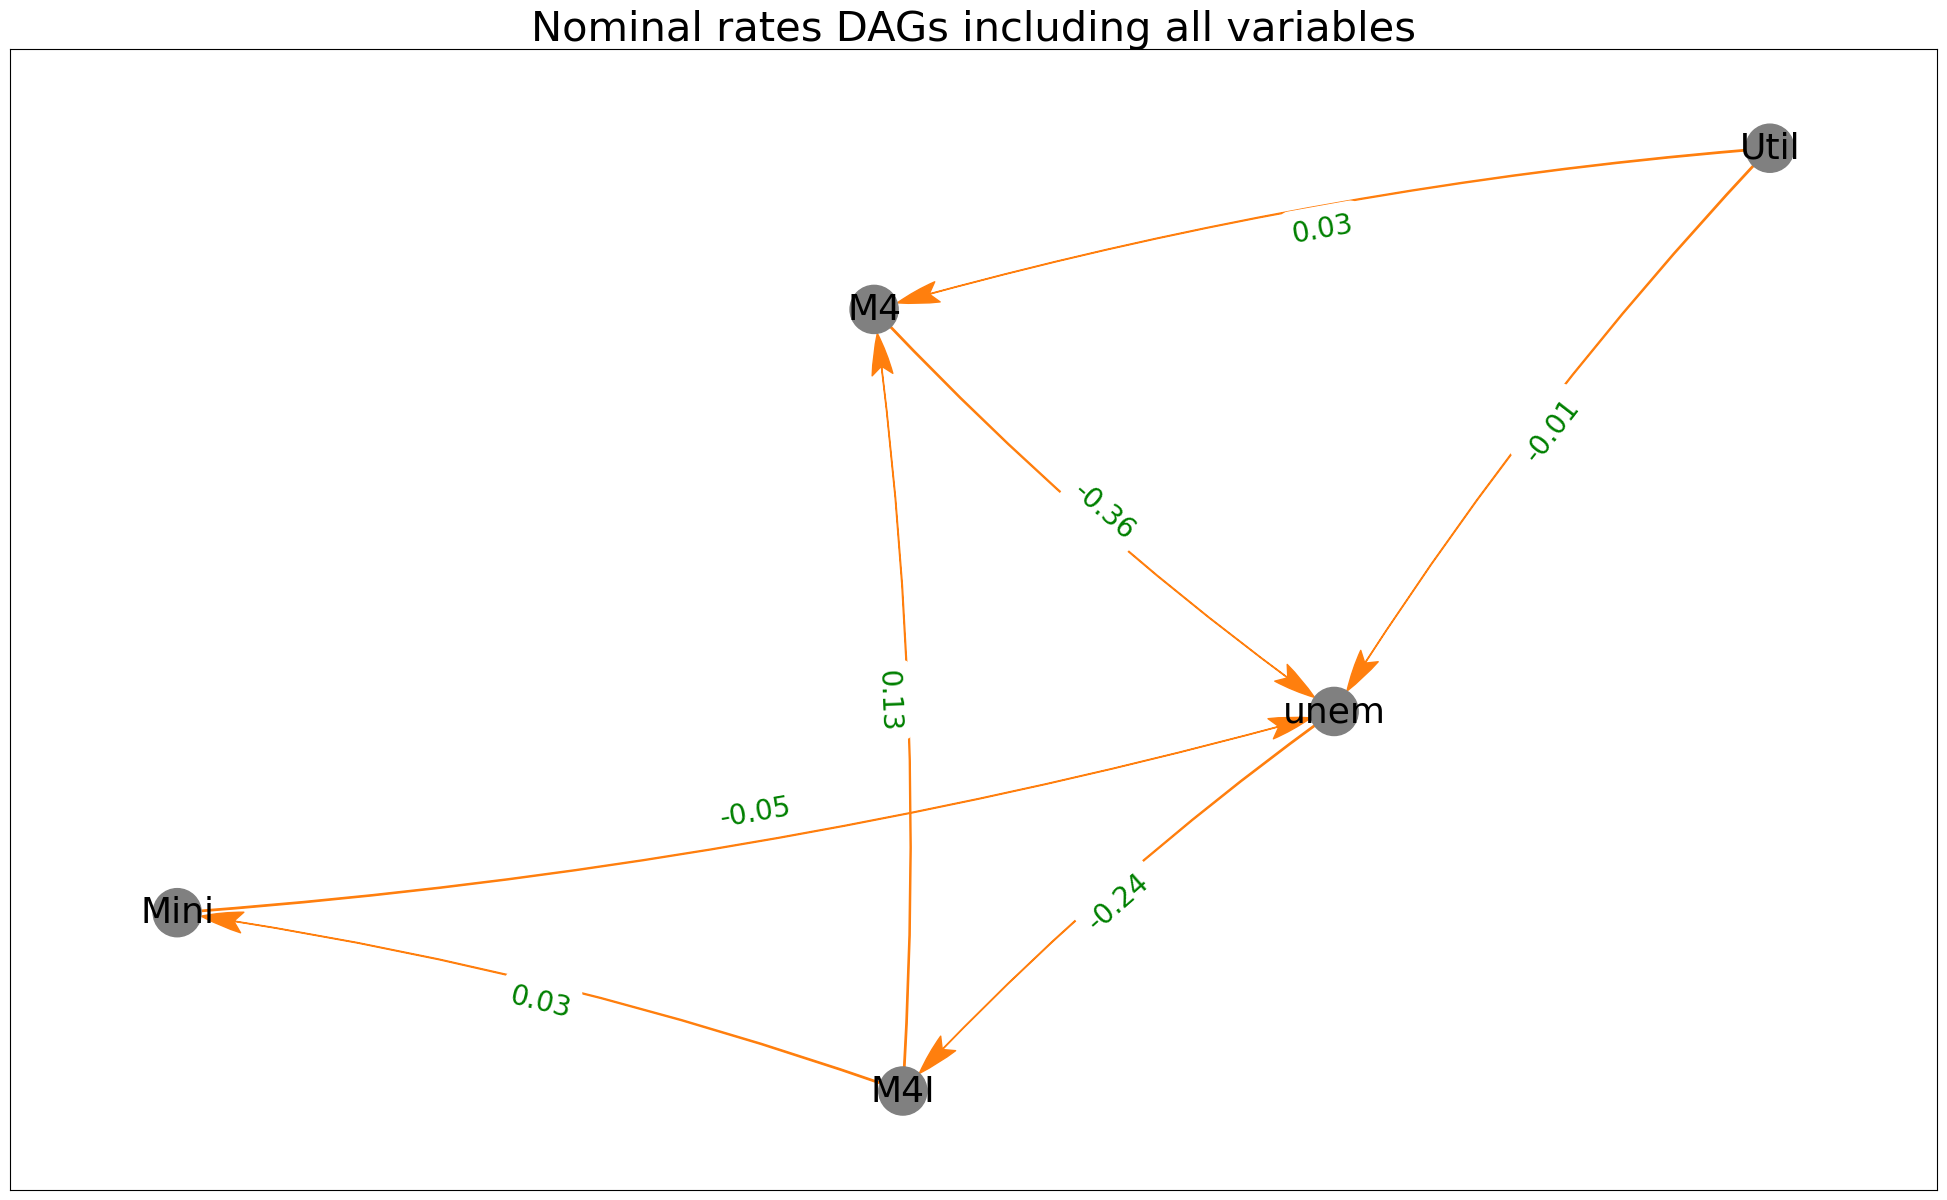

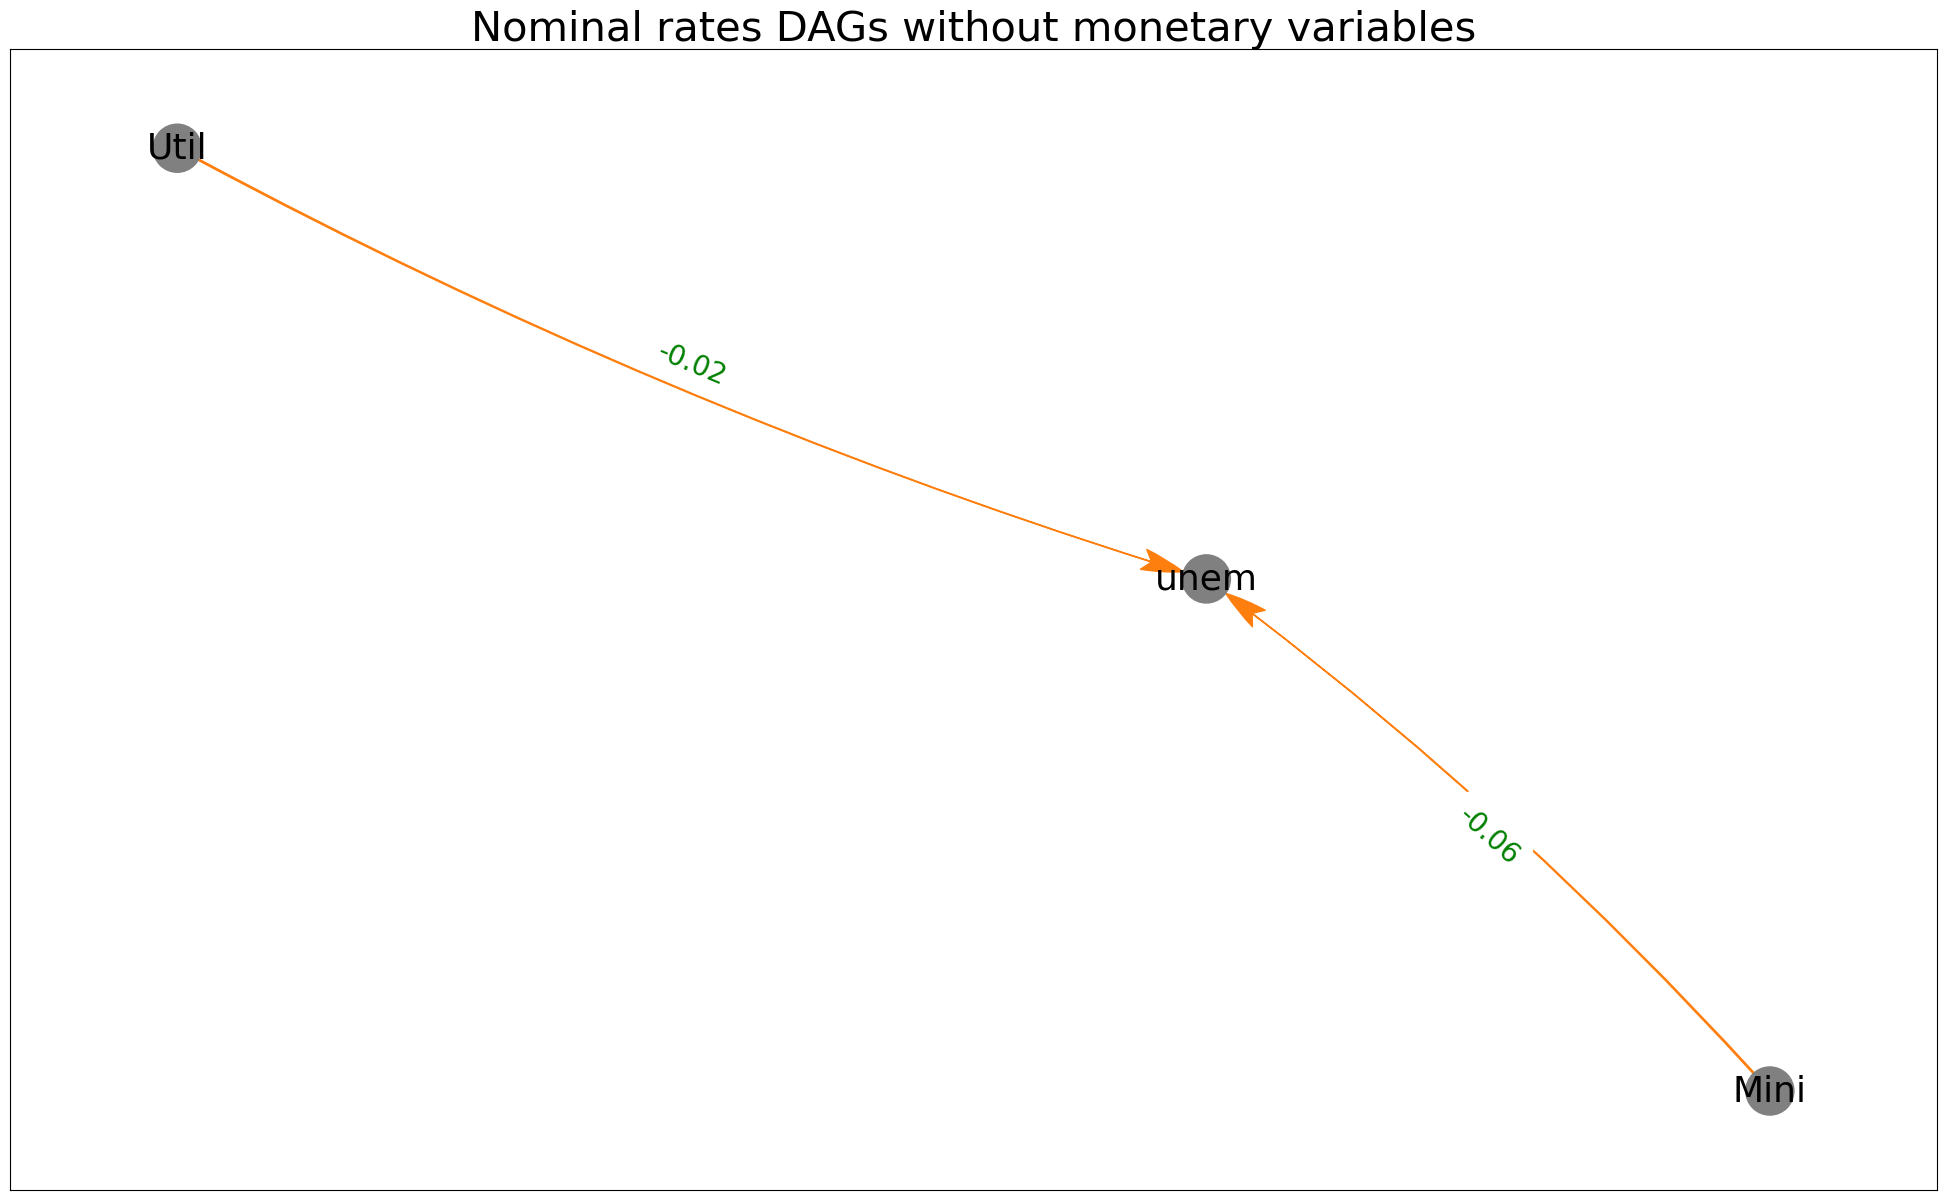

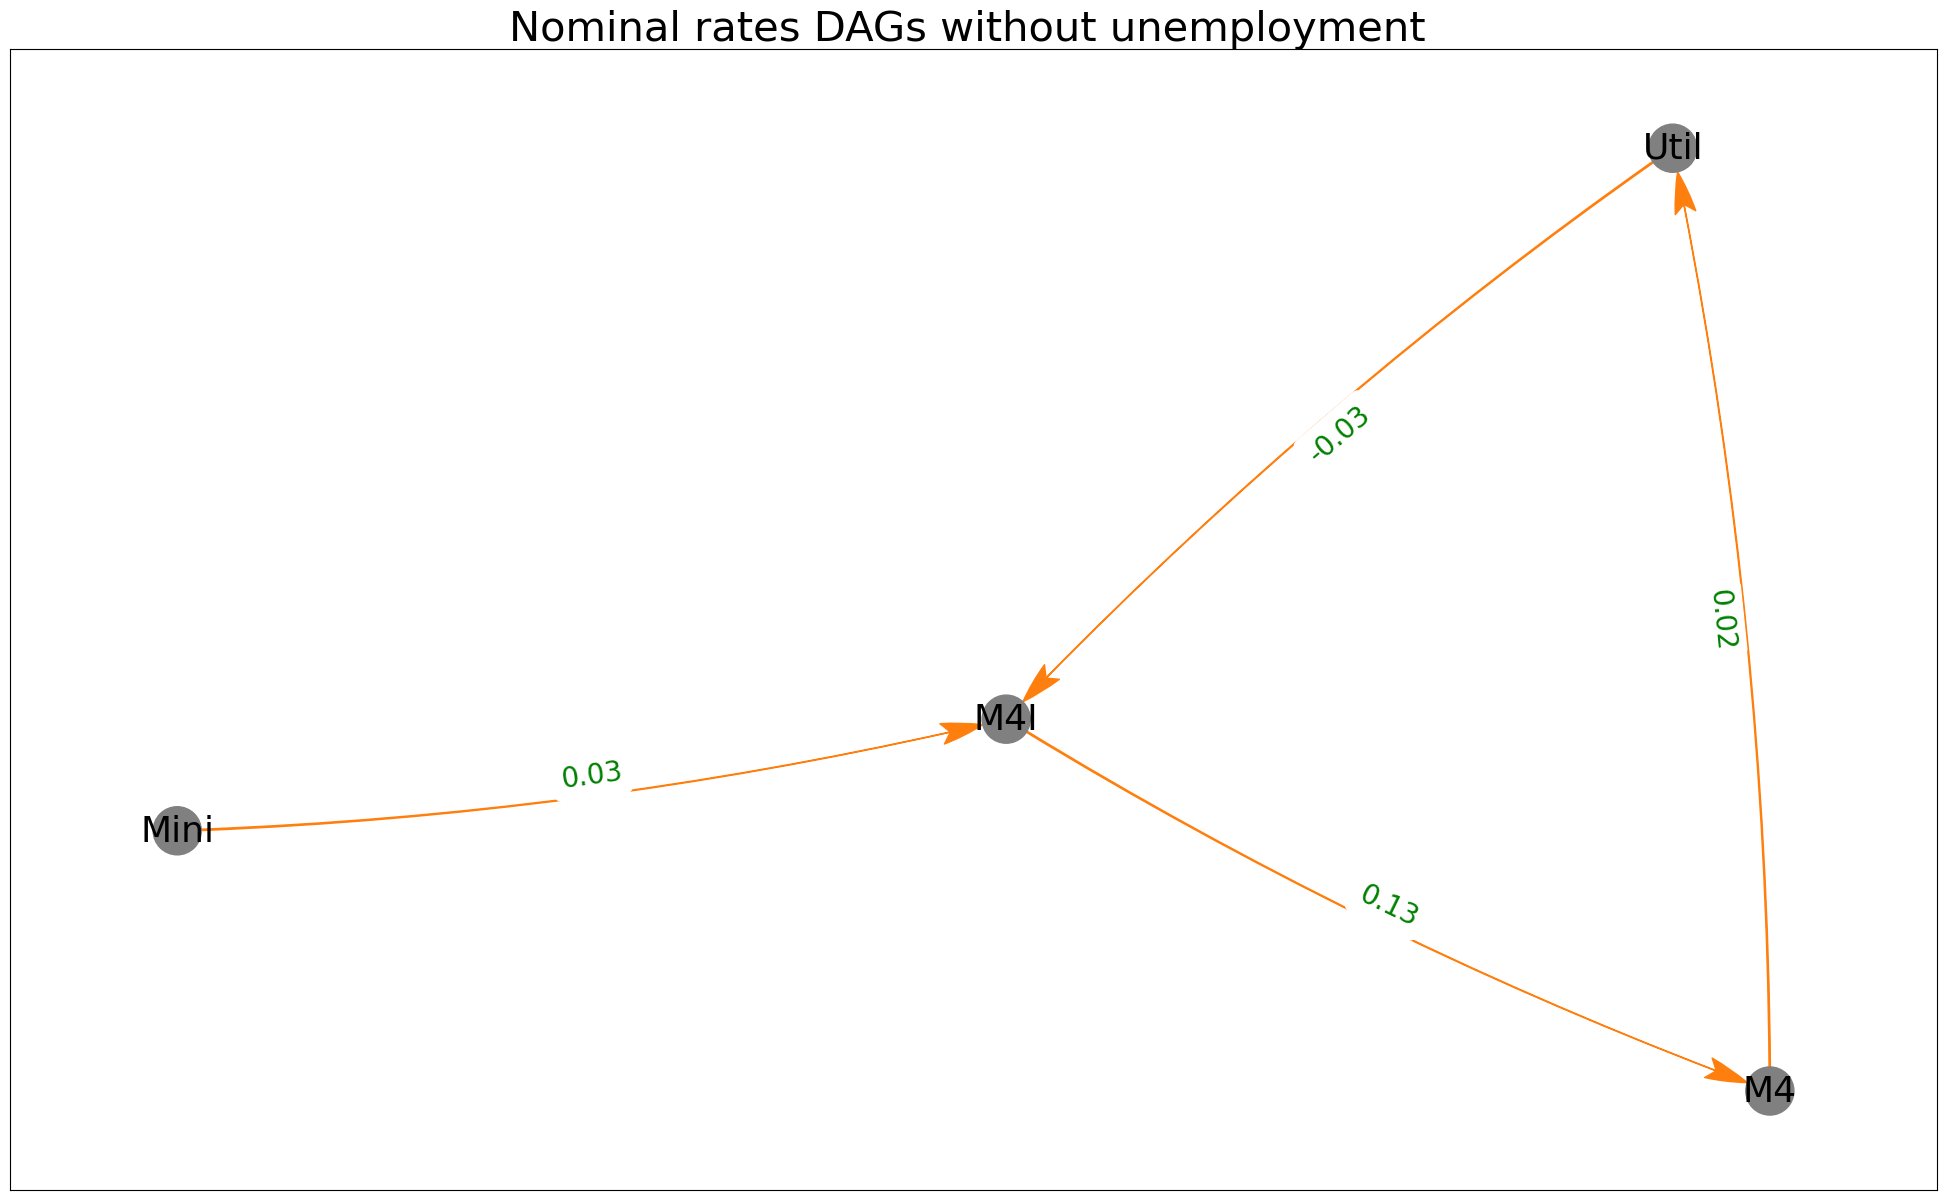

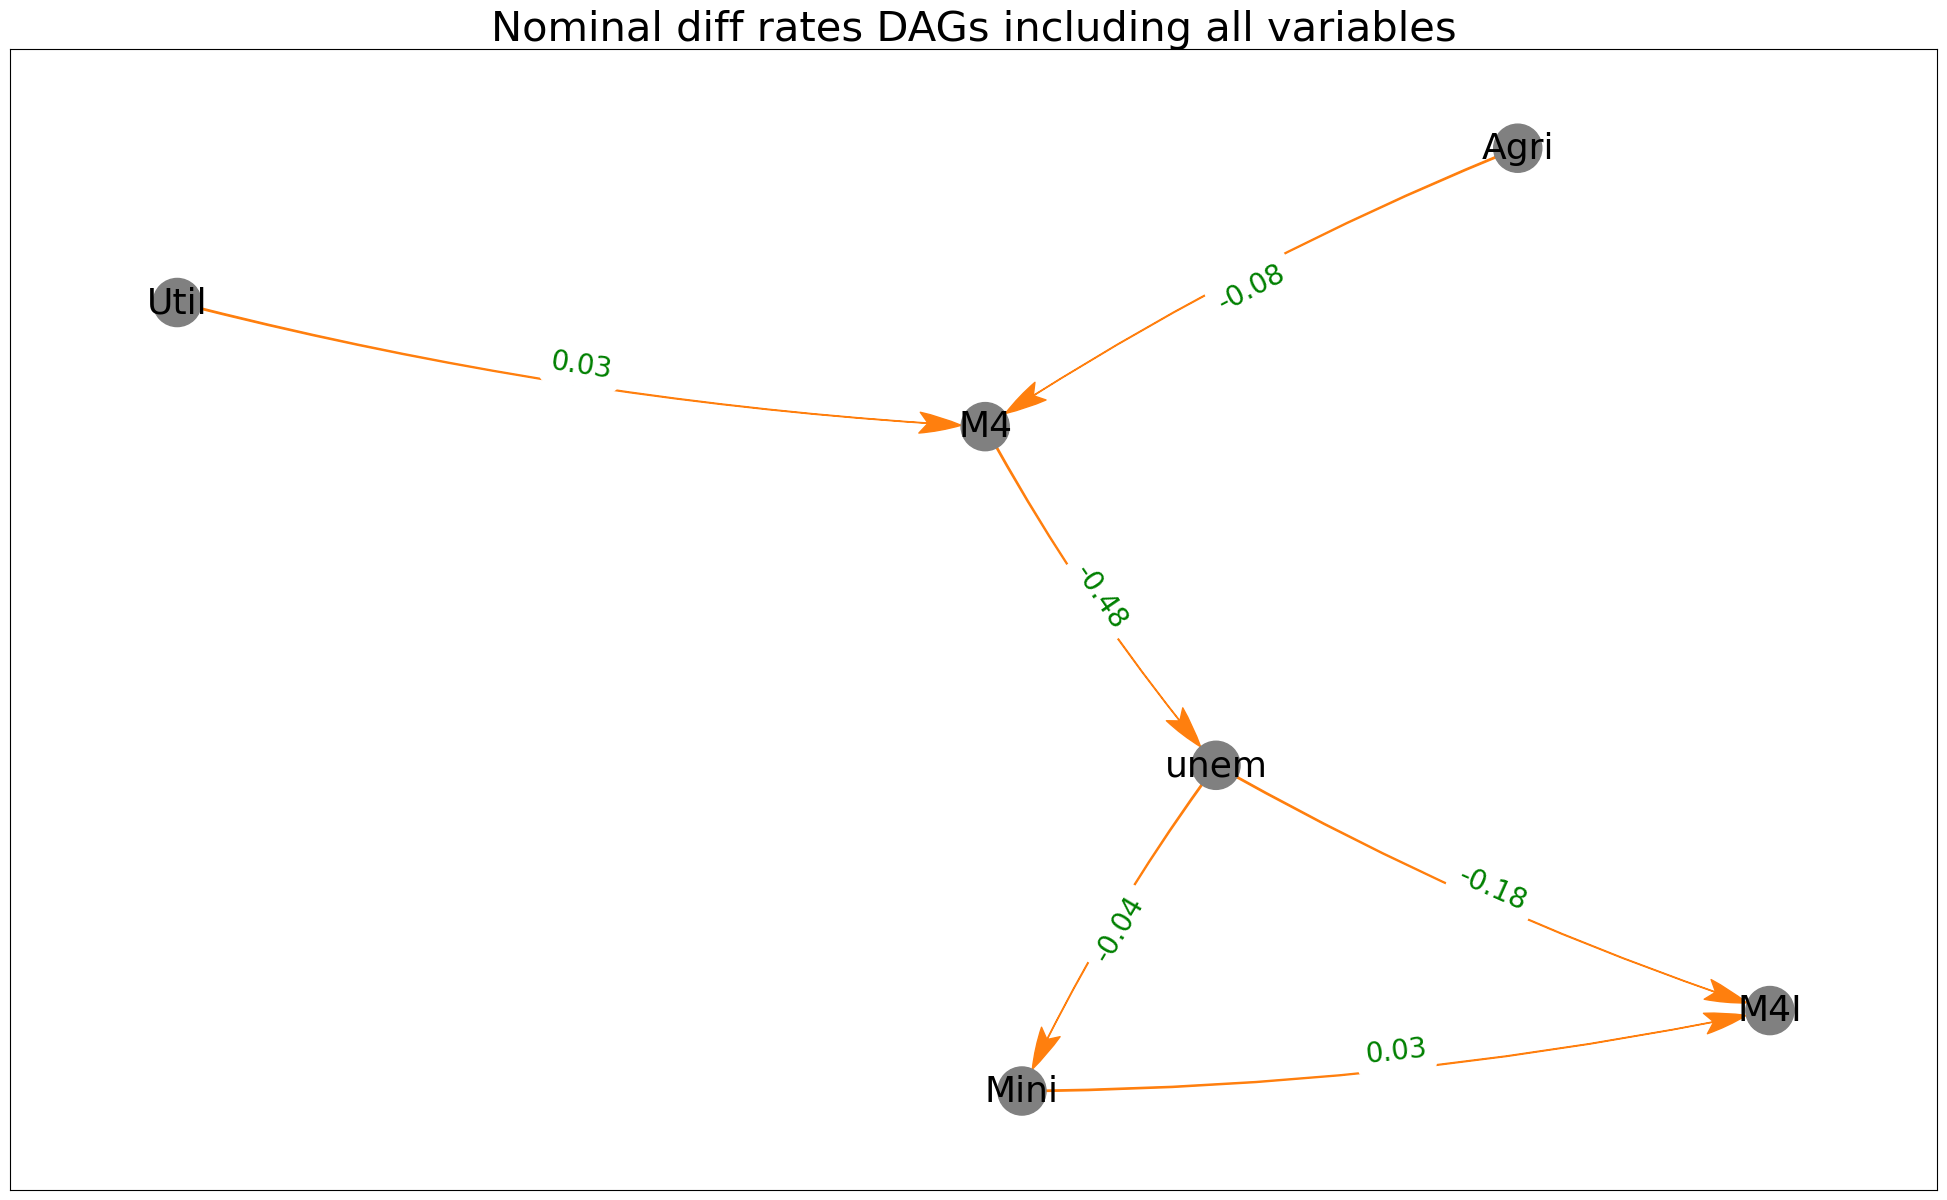

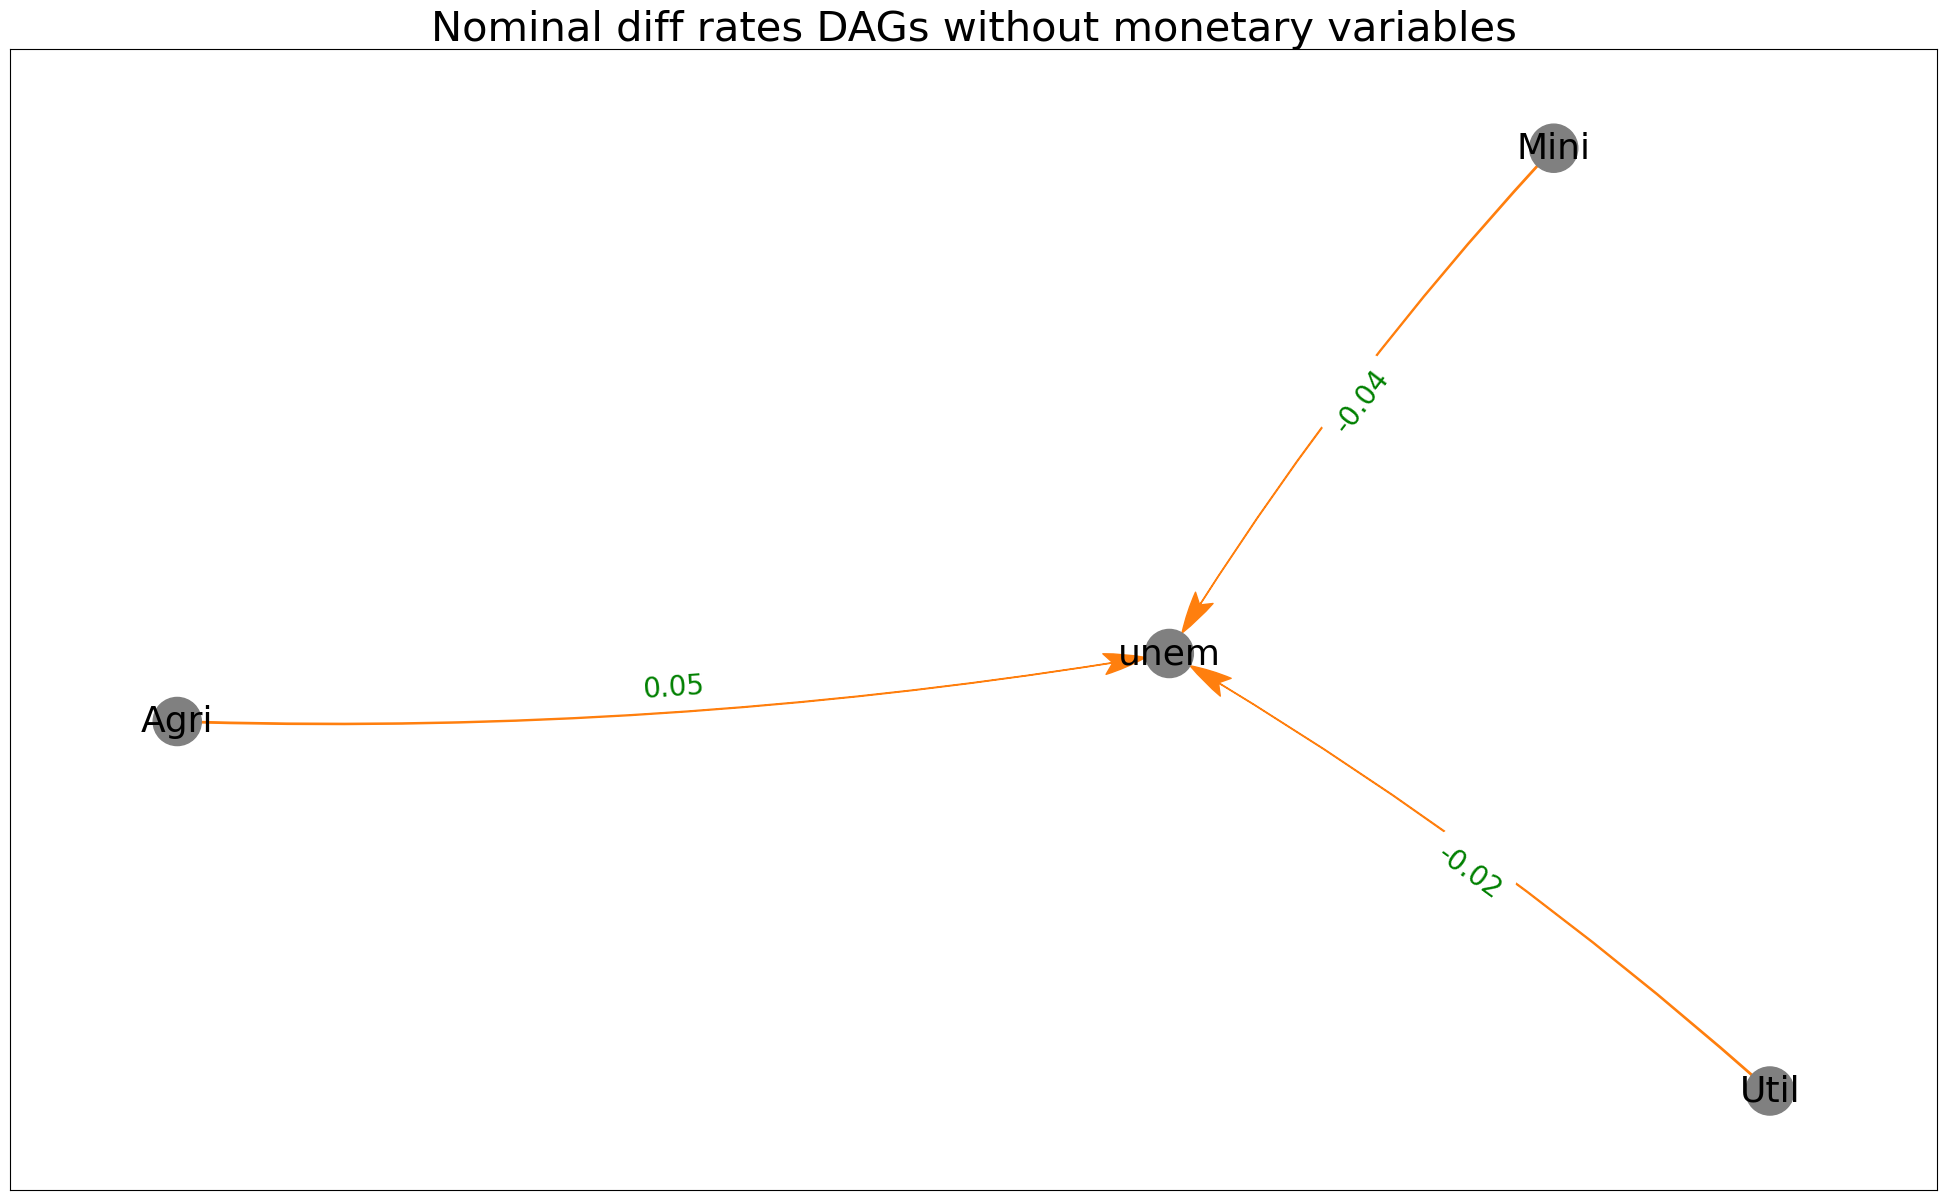

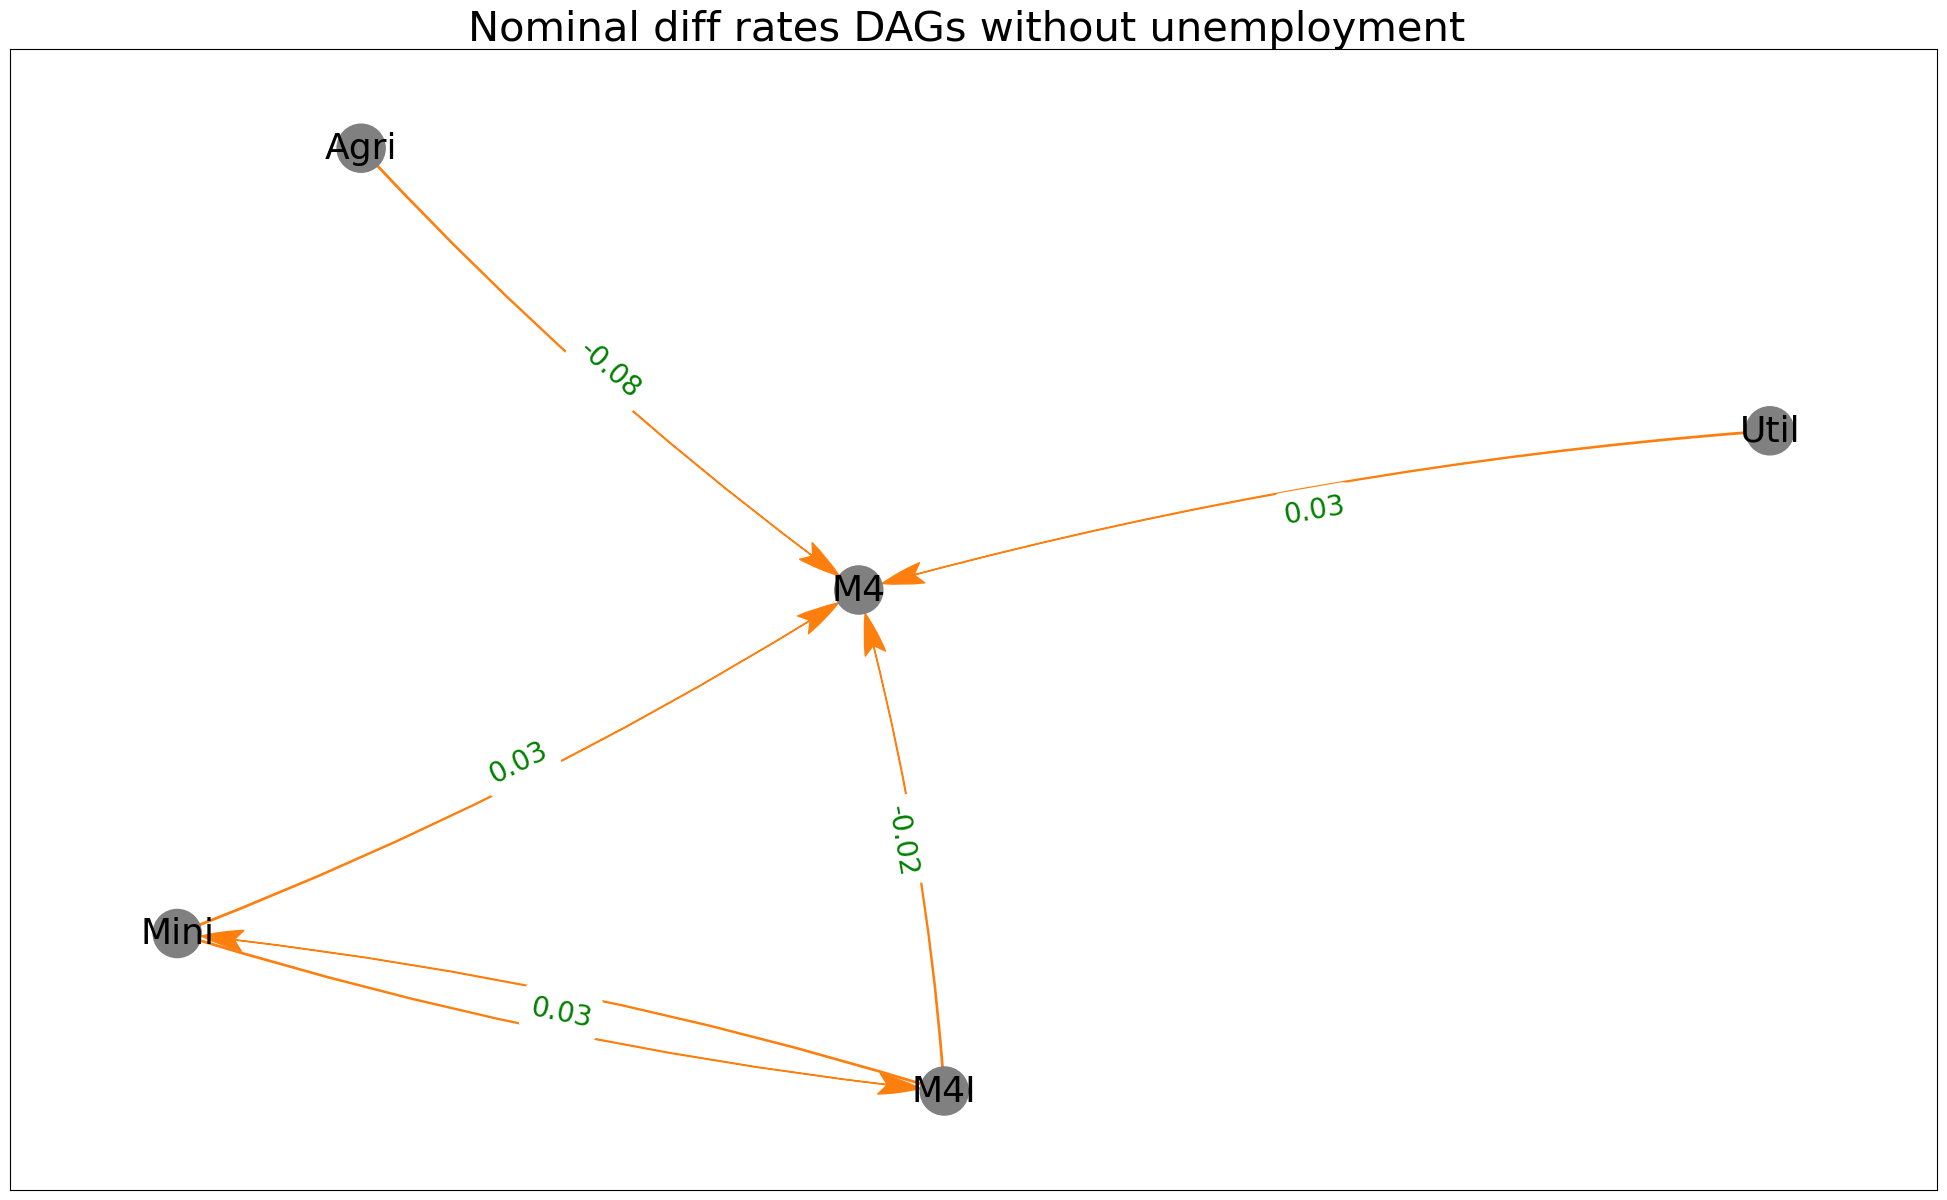

In [66]:
# Initialize a PdfPages object to save the plots in a PDF
#pp = PdfPages("DAGs_nominal")

title = ['Nominal rates DAGs including all variables',
        'Nominal rates DAGs without monetary variables',
        'Nominal rates DAGs without unemployment ',
        'Nominal diff rates DAGs including all variables',
        'Nominal diff rates DAGs without monetary variables',
        'Nominal diff rates DAGs without unemployment ']

# Plot DAGs for each dataframe
for i, key in enumerate(['Nominal rates (All variables)',
                         'Nominal rates (without Monetary)',
                         'Nominal rates (without unem)',
                         'Nominal diff rates (All variables)',
                         'Nominal diff rates (without Monetary)',
                         'Nominal diff rates (without unem)']):
    plot_df = full_DAG_dict[key]
    c = PC(plot_df)
    max_cond_vars = len(plot_df.keys()) - 2
    model = c.estimate(return_type='pdag', variant='orig', significance_level=0.01,
                       max_cond_vars=max_cond_vars, ci_test='pearsonr')
    edges = model.edges

    # Plot the DAG
    graph_DAG(edges, plot_df, title=title[i])
    
    # Save the plot to the PDF
#    pp.savefig()

# Close the PdfPages object
#pp.close()


In [67]:
df = full_df_rates_cluster.reset_index()

df = df.reset_index().set_index(['FIPS', 'TimePeriod'])

df1 = full_df_diff_cluster.reset_index()

df1 = df1.reset_index().set_index(['FIPS', 'TimePeriod'])

In [85]:
full_df_rates_cluster = pd.read_csv('full_df_rates_cluster.csv')

full_df_rates_cluster = full_df_rates_cluster.set_index(['FIPS', 'TimePeriod'])

full_df_diff_cluster = pd.read_csv('full_df_diff_cluster.csv')

full_df_diff_cluster = full_df_diff_cluster.set_index(['FIPS', 'TimePeriod'])

In [24]:
data_cluster_dict = {}
data_cluster_dict['Nominal rates with clusters'] = pd.get_dummies(full_df_rates_cluster,
                                                                       columns=['clusters'], drop_first=True)

data_cluster_dict['Nominal diff rates with clusters'] = pd.get_dummies(full_df_diff_cluster,
                                                                       columns=['clusters'], drop_first=True)

In [84]:
# full_df_rates_cluster.to_csv('full_df_rates_cluster.csv', index=True)

# full_df_diff_cluster.to_csv('full_df_diff_cluster.csv', index=True)

In [25]:
# List all the dummy variables created
cluster_dummies = [col for col in df.columns if col.startswith('clusters_')]

### Weighted Least Squares

Now we model the different WLS regressions with different weights and compare their results

In [28]:
# real_data = ai_dct_real["percent rates"].reset_index()

In [29]:
data = df.copy().reset_index().dropna()
map_data = map_data.reset_index()

merged_df = data.merge(map_data[['FIPS', 'Population']], on='FIPS', how='left')

In [30]:
real_data = ai_dct_real["diff rates"].dropna().reset_index()

In [31]:
# real_data = real_df.reset_index()

In [32]:
merged_df = data.merge(map_data[['FIPS', 'Population']], on='FIPS', how='left')

merged_df = merged_df.dropna()

merged_data = pd.merge(merged_df, real_data[['FIPS', 'TimePeriod', 'real_gdp']], on=['FIPS', 'TimePeriod'], how='left')

#merged_data.rename(columns={'All':'Real_gdp'}, inplace=True)

### Determining the models that predicts best

Here we use the average mean squares errors for each of the models fitted to determine which model predicts best by the smallest MSE. We include the pooled regressions and the weighted least square regressions.

In [87]:
data_cluster_dict = {
    'Nominal rates with clusters': pd.get_dummies(full_df_rates_cluster, columns=['clusters'], drop_first=True).reset_index(),
    'Nominal diff rates with clusters': pd.get_dummies(full_df_diff_cluster, columns=['clusters'], drop_first=True).reset_index()
}

result_df = analyze_wls_pooled_models(data_cluster_dict, dependent_var='unem', k=5, shuffle=True, random_state=42)

# Display the result DataFrame
print("\nResult DataFrame:")
display(result_df)


ValueError: exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False.